In [1]:
import exmel
from exmel.alignment import FrozenMatch

dataset = exmel.Dataset("dataset")

In [3]:
song_name_to_candidates: dict[str, list[FrozenMatch]] = {}
for song in dataset:
    candidates = exmel.align(
        song.melody,
        song.performance,
        exmel.AlignConfig(miss_tolerance=1, candidate_min_score=0, hop_length=1),
        skip_wisp=True)
    song_name_to_candidates[song.name] = candidates

Scanning alignments:   0%|          | 0/211 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/363 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/790 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/445 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/338 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/192 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/507 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/317 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/650 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/538 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/522 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/348 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/397 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/328 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/344 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/290 [00:00<?, ?it/s]

Scanning alignments:   0%|          | 0/535 [00:00<?, ?it/s]

In [6]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

score_model = exmel.XGBoostModel('xgb_hop1_miss1_len10_large.json', 0)
name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    name_to_scores[song.name] = score_model(candidates)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

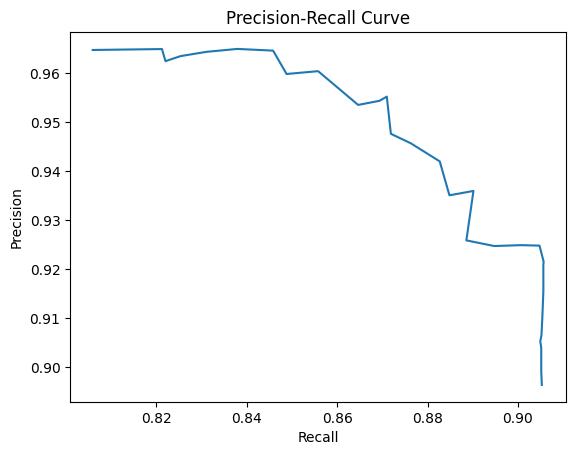

In [10]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [11]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8998511045550991, pre=0.8964451842558051, rec=0.9053047261851696
p=1, f1=0.9010766363013607, pre=0.8991694421442054, rec=0.9051666427827945
p=2, f1=0.9035066508847446, pre=0.9040127181165675, rec=0.9051666427827945
p=3, f1=0.9040029476604349, pre=0.9053140336151124, rec=0.9049524149919964
p=4, f1=0.9047960396889638, pre=0.9066068321762323, rec=0.905214612560262
p=5, f1=0.9065171118671342, pre=0.9100925878837048, rec=0.9054063629335769
p=6, f1=0.9093788436305884, pre=0.9155979393970894, rec=0.9056397722662118
p=7, f1=0.912004647684145, pre=0.9207547241314814, rec=0.9056295670660955
p=8, f1=0.912559279721249, pre=0.9215890476670074, rec=0.9056903196201466
p=9, f1=0.9137604922516425, pre=0.9248217873465352, rec=0.9047789417966474
p=10, f1=0.9116879167962263, pre=0.9249128026554881, rec=0.9007038194164376
p=11, f1=0.9080707155177693, pre=0.9247378747054775, rec=0.894746900705934
p=12, f1=0.9055627744495444, pre=0.9258854926230862, rec=0.8885934558346685
p=13, f1=0.911273521035639

# Linear

In [12]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

score_model = exmel.LinearModel(exmel.get_linear_model_default_weights(), 0)
name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    name_to_scores[song.name] = score_model(candidates)

  0%|          | 0/17 [00:00<?, ?it/s]

In [13]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

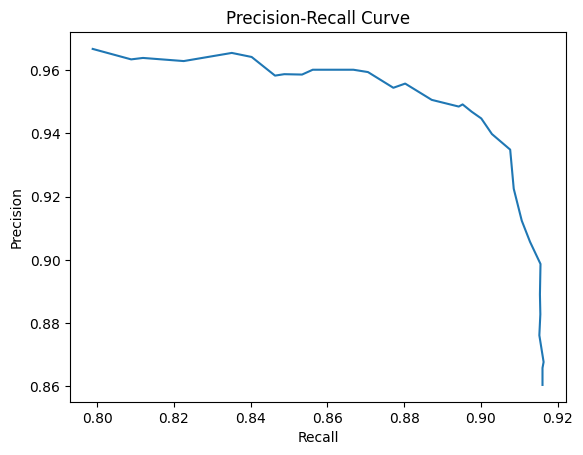

In [14]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [15]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.885950229690734, pre=0.860472306906801, rec=0.916053898023922
p=1, f1=0.8887138759024327, pre=0.8658209095832851, rec=0.916053898023922
p=2, f1=0.8898589245256466, pre=0.8677194259087591, rec=0.9163430453605538
p=3, f1=0.8934515321820805, pre=0.8761503008914207, rec=0.915232414210684
p=4, f1=0.8971198800098183, pre=0.8828094851358405, rec=0.9154924441830931
p=5, f1=0.9002230479743902, pre=0.8890677996531027, rec=0.91538505928971
p=6, f1=0.9053627680000919, pre=0.8986984953185144, rec=0.91553244329761
p=7, f1=0.907467645609553, pre=0.9057047029575587, rec=0.9128013819102104
p=8, f1=0.9099618670539267, pre=0.9123832578707629, rec=0.9106500326820258
p=9, f1=0.913891553557754, pre=0.9224630494238378, rec=0.9085609979224802
p=10, f1=0.9192738459107368, pre=0.9348360009688147, rec=0.907633259655881
p=11, f1=0.9194647604576235, pre=0.9397608210500248, rec=0.9028758256969668
p=12, f1=0.9204124019342212, pre=0.9446887569828145, rec=0.9001025615361754
p=13, f1=0.9202868272070024, pre=0

# Weighted Sum Velocity

In [ ]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    candidates = song_name_to_candidates[song.name]
    scores: list[float] = []
    for c in candidates:
        v = sum(event.velocity for event in c.events) / 128
        w = (1 - c.sum_miss / len(c.events))
        scores.append(v*w)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [17]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

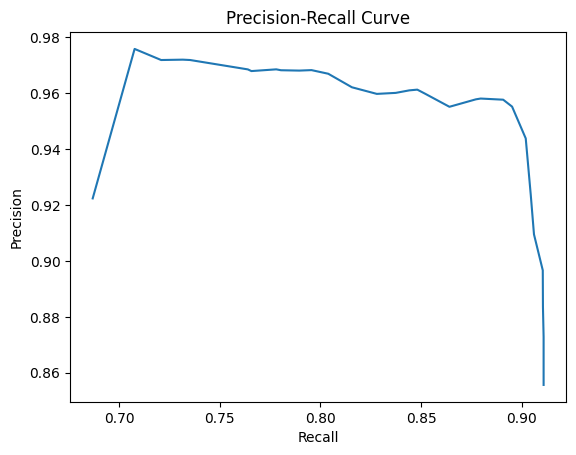

In [18]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [19]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8808441924715992, pre=0.8556594453543847, rec=0.9108368767444849
p=1, f1=0.8833856615986706, pre=0.8604328648307442, rec=0.9108368767444849
p=2, f1=0.8896911143505438, pre=0.8728275322910217, rec=0.9108368767444849
p=3, f1=0.8950378652868062, pre=0.8835533921613554, rec=0.9105092179371697
p=4, f1=0.9015752860101249, pre=0.8966072570213933, rec=0.9104259863098155
p=5, f1=0.9057336155648782, pre=0.9094532057288373, rec=0.9060567650461239
p=6, f1=0.9121326750506678, pre=0.9235467449550591, rec=0.9044593904555703
p=7, f1=0.9212319839245888, pre=0.9437495994323444, rec=0.9019611550740438
p=8, f1=0.9232794795930259, pre=0.9551174285285315, rec=0.895176889308984
p=9, f1=0.9219846183333215, pre=0.9575884814070105, rec=0.8907613679318515
p=10, f1=0.9157980710090908, pre=0.9579969553754433, rec=0.879564057552709
p=11, f1=0.9142925908190184, pre=0.9577163807895701, rec=0.8771897355433103
p=12, f1=0.905591716966151, pre=0.9550530728911364, rec=0.8640640511663249
p=13, f1=0.90054012461625

# Weighted Sum Vel V2

In [20]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    note_mean_song = song_stats(song.melody, song.performance)["note_mean_song"]
    candidates = song_name_to_candidates[song.name]
    scores: list[float] = []
    for c in candidates:
        v = sum(event.velocity for event in c.events) / 128
        w1 = (1 - c.sum_miss / len(c.events))
        w2 = sum(event.note for event in c.events) / len(c.events) / note_mean_song
        scores.append(v*w1*w2)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

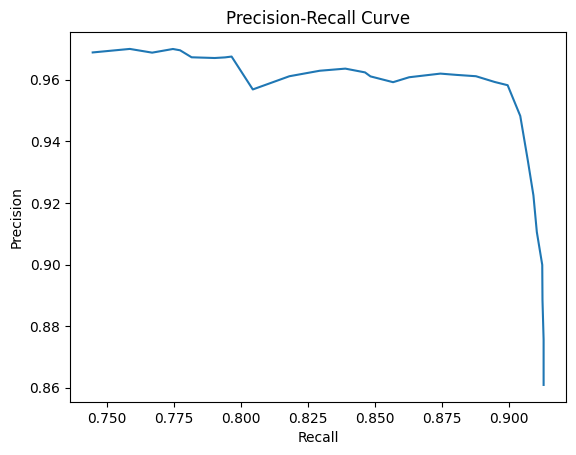

In [22]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [23]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8846696656971813, pre=0.8609093372009319, rec=0.9129707928312941
p=1, f1=0.8880646884886927, pre=0.8673683413190254, rec=0.9129707928312941
p=2, f1=0.8922829495187712, pre=0.8756139362264758, rec=0.9129707928312941
p=3, f1=0.8985595254152289, pre=0.8884451382907033, rec=0.9125526160819214
p=4, f1=0.9040599167297177, pre=0.89987009295743, rec=0.9124637099755218
p=5, f1=0.9084602873344745, pre=0.910538078226418, rec=0.9104432337112851
p=6, f1=0.9139594532953081, pre=0.9224409128864802, rec=0.9091709071752849
p=7, f1=0.9190428943111297, pre=0.9339549083575789, rec=0.9070471115974952
p=8, f1=0.9249017672476504, pre=0.9482424965236727, rec=0.904256489555983
p=9, f1=0.9271619803669667, pre=0.9582115719444144, rec=0.899551366253924
p=10, f1=0.9248302273591154, pre=0.9592652846609762, rec=0.8947048504729347
p=11, f1=0.9219474425618283, pre=0.96112959230848, rec=0.8877298124331888
p=12, f1=0.9177859768413618, pre=0.9615669522258967, rec=0.8804045755541091
p=13, f1=0.9146953847304785, 

In [24]:
from exmel.event import MelEvent
from exmel.sequence import MelodyLike, Melody
from exmel.eval import EvaluationResult
from exmel.io import PathLike

def evaluate_melody(
    gt: MelodyLike,
    pred: MelodyLike,
    tolerance: float = 0.1,
    modulo: bool = True,
    plot: bool = True,
    save_path: PathLike | None = None,
) -> EvaluationResult:
    """
    Evaluate the accuracy of a predicted melody against a ground truth melody.
    Creates a piano roll visualization with color coding for tp/fp/fn.
    
    Args:
        gt: Ground truth melody
        pred: Predicted melody
        tolerance: Time tolerance for matching notes (seconds)
        modulo: Whether to use modulo 12 for note matching
        plot: Whether to plot the evaluation result
        save_path: Optional path to save the visualization plot
    """
    gt = Melody(gt)
    pred = Melody(pred)

    if modulo:
        gt %= 12
        pred %= 12
    
    # Track which notes are tp, fp, fn for visualization
    tp_notes: list[MelEvent] = []
    fp_notes: list[MelEvent] = []
    fn_notes: list[MelEvent] = []
    
    # Find true positives and mark matched gt notes
    matched_gt_indices = set()
    for p_event in pred:
        nearest = gt.nearest(p_event)
        if nearest is not None:
            if abs(p_event.time - nearest.time) <= tolerance:
                tp_notes.append(p_event)
            else:
                fp_notes.append(p_event)
        else:
            fp_notes.append(p_event)
    
    # Find false negatives (unmatched gt notes)
    for g_event in gt:
        nearest = pred.nearest(g_event)
        if nearest is None or abs(g_event.time - nearest.time) > tolerance:
            fn_notes.append(g_event)
    
    # Calculate metrics
    tp = len(tp_notes)
    fp = len(fp_notes)
    fn = len(fn_notes)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Create piano roll visualization
    if plot:
        fig = None
    else:
        fig = None
    
    return EvaluationResult(tp, fp, fn, precision, recall, f1_score, fig)

In [25]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

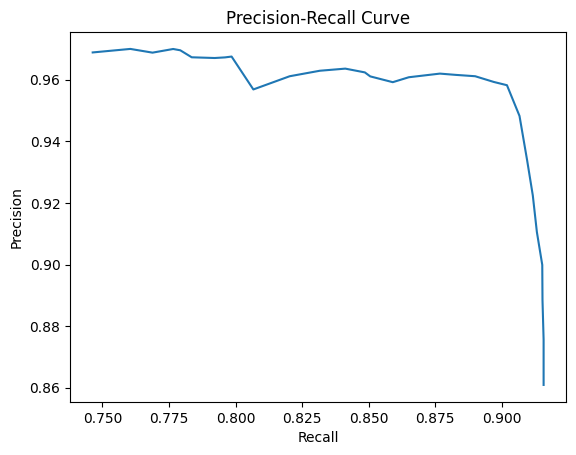

In [26]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [27]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8860462157993814, pre=0.8609093372009319, rec=0.9157130070175608
p=1, f1=0.8894412385908927, pre=0.8673683413190254, rec=0.9157130070175608
p=2, f1=0.8937090808825103, pre=0.8756139362264758, rec=0.9157130070175608
p=3, f1=0.8999856567789681, pre=0.8884451382907033, rec=0.915294830268188
p=4, f1=0.9054890691600956, pre=0.89987009295743, rec=0.9152081916581305
p=5, f1=0.9098894397648524, pre=0.910538078226418, rec=0.9131877153938939
p=6, f1=0.9152968647332603, pre=0.9224409128864802, rec=0.9116542581564012
p=7, f1=0.9203845127321632, pre=0.9339549083575789, rec=0.9095003983107198
p=8, f1=0.9262199692961961, pre=0.9482424965236727, rec=0.9066572018591841
p=9, f1=0.9285118754884462, pre=0.9582115719444144, rec=0.901949213236549
p=10, f1=0.926152913504133, pre=0.9592652846609762, rec=0.8970293286727984
p=11, f1=0.9232411931451294, pre=0.96112959230848, rec=0.890002806274047
p=12, f1=0.9191225191178947, pre=0.9615669522258967, rec=0.8827056031446587
p=13, f1=0.9160371829477654, pr

# Adjusted Weighted Sum Vel

In [38]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

ERR_WEIGHT = 0.5

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    song_dict = song_stats(song.melody, song.performance)
    note_mean_song = song_dict["note_mean_song"]
    duration_per_event = song_dict["duration_per_event"]
    candidates = song_name_to_candidates[song.name]
    scores: list[float] = []
    for c in candidates:
        v = sum(event.velocity for event in c.events) / 128
        w1 = (1 - c.sum_miss / len(c.events))
        w2 = sum(event.note for event in c.events) / len(c.events) / note_mean_song
        scores.append(v*w1*w2 - ERR_WEIGHT*c.sum_error/duration_per_event)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [39]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np

pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

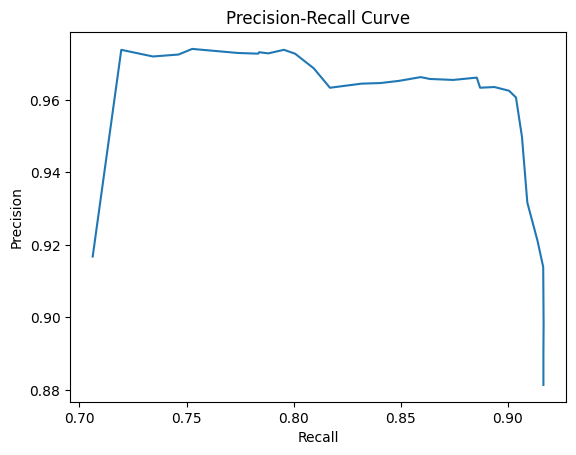

In [30]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [40]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8979985414897371, pre=0.8832006529118236, rec=0.9164189491177588
p=1, f1=0.9005439059445114, pre=0.8882903938117312, rec=0.9164035019651711
p=2, f1=0.904766483176695, pre=0.8967918042051484, rec=0.9164112189181716
p=3, f1=0.9115185270153896, pre=0.9104483276457949, rec=0.9163287766149444
p=4, f1=0.9152329392271167, pre=0.9207748682665517, rec=0.9134706489066471
p=5, f1=0.9196379481679604, pre=0.9315890386081549, rec=0.9106006368062171
p=6, f1=0.9261637504325333, pre=0.9467057664098391, rec=0.9077790139063954
p=7, f1=0.9309790307511382, pre=0.958193842703559, rec=0.9065067895104517
p=8, f1=0.9293295228916183, pre=0.961893343243706, rec=0.9004682015775194
p=9, f1=0.925723003501035, pre=0.9629923336075686, rec=0.8932245452285157
p=10, f1=0.9231008222670519, pre=0.9631369440551296, rec=0.888790113686731
p=11, f1=0.9221761287236262, pre=0.9648455289288717, rec=0.8855995768239648
p=12, f1=0.9165622791560755, pre=0.9643506421291751, rec=0.8758729921635551
p=13, f1=0.9096089212366004

In [31]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.8972307678239612, pre=0.8813463218002513, rec=0.9167037303242247
p=1, f1=0.9016143550677508, pre=0.890167792575589, rec=0.9167037303242247
p=2, f1=0.9054930445862985, pre=0.8978756306233558, rec=0.9167983019149188
p=3, f1=0.913419357880829, pre=0.9138582564241492, rec=0.9166133795952949
p=4, f1=0.9156473282144684, pre=0.9210658172906587, rec=0.9139722511171634
p=5, f1=0.918926054979641, pre=0.9316622480299619, rec=0.9091896096614622
p=6, f1=0.9271365483028717, pre=0.949820296901014, rec=0.9066847221862833
p=7, f1=0.9305653832135412, pre=0.9606451341097921, rec=0.9038867785260494
p=8, f1=0.9297285613600571, pre=0.9625039575676323, rec=0.9006671349148188
p=9, f1=0.9263256286458521, pre=0.9635279400988445, rec=0.8938170413659254
p=10, f1=0.9222896003015341, pre=0.9633353645011963, rec=0.8871363102994553
p=11, f1=0.9227348572154547, pre=0.9661258626698638, rec=0.8855668866285658
p=12, f1=0.9163640949053261, pre=0.9654884919965719, rec=0.874593063978753
p=13, f1=0.9102056276774677